In [14]:
#--------------------------------------------------------------------------------
# Module 1: Loading pickled big boi data for GAN model
#--------------------------------------------------------------------------------

import pickle
import os

# Ensure the directory "Processed data" exists before attempting to load the file
if os.path.exists("Processed data/data_encoded.pkl"):
    with open("Processed data/data_encoded.pkl", "rb") as file:
        data_encoded = pickle.load(file)
else:
    print("The pickled file does not exist in the specified directory.")


In [15]:
#--------------------------------------------------------------------------------
# Module 2: Define the Generator model
#--------------------------------------------------------------------------------

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization

# Define the size of the random noise input (latent dimension)
latent_dim = 100
num_features = data_encoded.shape[1]

# Define the Generator model
def build_generator():
    model = Sequential()

    # First hidden layer
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    # Second hidden layer
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    # Third hidden layer
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    # Output layer
    model.add(Dense(num_features, activation='tanh'))

    return model

generator = build_generator()
generator.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 256)               25856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 256)               0         
                                                                 
 batch_normalization_3 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_8 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_4 (Bat  (None, 512)               2048      
 chNormalization)                                     

In [16]:
#--------------------------------------------------------------------------------
# Module 3: Define the Discriminator model
#--------------------------------------------------------------------------------

def build_discriminator():
    model = Sequential()

    # First hidden layer
    model.add(Dense(512, input_dim=num_features))
    model.add(LeakyReLU(alpha=0.2))
    
    # Second hidden layer
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))  # Sigmoid activation to get probabilities as output

    return model

discriminator = build_discriminator()
discriminator.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 512)               17457664  
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 257       
                                                                 
Total params: 17589249 (67.10 MB)
Trainable params: 17589249 (67.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
#--------------------------------------------------------------------------------
# Module 4: Compile the Discriminator model
#   1. Using legacy Keras optimizer as i have an m2 chip macbook
#--------------------------------------------------------------------------------

from tensorflow.keras.optimizers.legacy import Adam

# Compile the Discriminator using the legacy optimizer
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])



In [18]:
#--------------------------------------------------------------------------------
# Module 5: Combined GAN Structure
#   OBS! Discriminator trainable=False as we dont wants to change its weights 
#   while during this initial generator training process, as it ruins the model.
#--------------------------------------------------------------------------------

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Ensure that the discriminator is not trainable when combined with the generator
discriminator.trainable = False

# Define the GAN's input (noise) and output (discriminator's probability for the generated sample)
gan_input = Input(shape=(latent_dim,))
generated_sample = generator(gan_input)
gan_output = discriminator(generated_sample)

# Define the combined GAN model
gan = Model(gan_input, gan_output)

# Compile the GAN using the same loss and optimizer as the discriminator
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

gan.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_2 (Sequential)   (None, 34096)             35638320  
                                                                 
 sequential_3 (Sequential)   (None, 1)                 17589249  
                                                                 
Total params: 53227569 (203.05 MB)
Trainable params: 35634736 (135.94 MB)
Non-trainable params: 17592833 (67.11 MB)
_________________________________________________________________


In [19]:
#--------------------------------------------------------------------------------
# Module 6: Training the GAN
#--------------------------------------------------------------------------------

import numpy as np

# Define training hyperparameters
epochs = 100
batch_size = 128
half_batch = batch_size // 2

# Lists to hold loss values for plotting after training
d_losses = []
g_losses = []

for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------
    
    # Select a random half batch of real samples
    idx = np.random.randint(0, data_encoded.shape[0], half_batch)
    real_samples = data_encoded.iloc[idx].values.astype('float32')

    # Generate half batch of fake samples
    noise = np.random.normal(0, 1, (half_batch, latent_dim)).astype('float32')
    fake_samples = generator.predict(noise).astype('float32')

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(real_samples, np.ones((half_batch, 1)).astype('float32'))
    d_loss_fake = discriminator.train_on_batch(fake_samples, np.zeros((half_batch, 1)).astype('float32'))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------
    
    noise = np.random.normal(0, 1, (batch_size, latent_dim)).astype('float32')
    valid_y = np.ones((batch_size, 1)).astype('float32')
    
    # Train the generator
    g_loss = gan.train_on_batch(noise, valid_y)

    # Save losses for plotting
    d_losses.append(d_loss[0])
    g_losses.append(g_loss)

    # Print the progress
    print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

print("Training finished.")




2/2 [==============================] - 0s 11ms/step
0/100 [D loss: 0.33512309394427575 | D accuracy: 95.3125] [G loss: 0.9141632318496704]
2/2 [==============================] - 0s 11ms/step
1/100 [D loss: 0.19788852334478288 | D accuracy: 100.0] [G loss: 0.8679201602935791]
2/2 [==============================] - 0s 11ms/step
2/100 [D loss: 0.22192691266695838 | D accuracy: 96.09375] [G loss: 0.8599892854690552]
2/2 [==============================] - 0s 11ms/step
3/100 [D loss: 0.25792622567259205 | D accuracy: 89.0625] [G loss: 0.7897990345954895]
2/2 [==============================] - 0s 10ms/step
4/100 [D loss: 0.14219826852150774 | D accuracy: 99.21875] [G loss: 0.9332106709480286]
2/2 [==============================] - 0s 12ms/step
5/100 [D loss: 0.10009407368306711 | D accuracy: 96.875] [G loss: 0.8197108507156372]
2/2 [==============================] - 0s 11ms/step
6/100 [D loss: 0.10599806299433112 | D accuracy: 96.09375] [G loss: 1.0626091957092285]
2/2 [======================

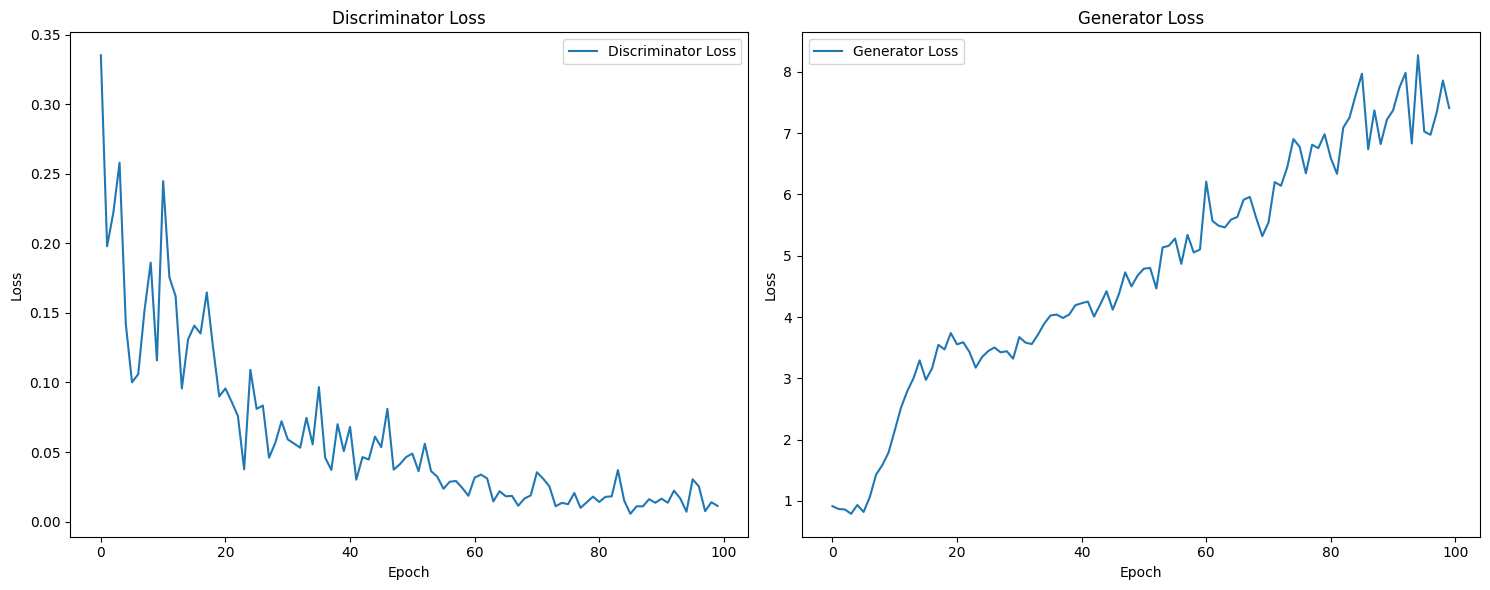

In [20]:
#--------------------------------------------------------------------------------
# Module 7: Visualize the Loss
#--------------------------------------------------------------------------------

import matplotlib.pyplot as plt

# Plot Discriminator and Generator Loss
plt.figure(figsize=(15, 6))

# Plotting Discriminator Loss
plt.subplot(1, 2, 1)
plt.plot(d_losses, label='Discriminator Loss')
plt.title('Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Generator Loss
plt.subplot(1, 2, 2)
plt.plot(g_losses, label='Generator Loss')
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [22]:
#--------------------------------------------------------------------------------
# Module 8: Display synthesied data in non-normalised format
#--------------------------------------------------------------------------------

